In [2]:
import numpy as np
from tensorflow import keras
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
import matplotlib.patches as patches
from sklearn.preprocessing import MinMaxScaler
import copy
from tqdm.notebook import tqdm

In [4]:
def load_dataset_and_trajectories(filename):
    npz = np.load(filename, allow_pickle=True)
    print(npz.files)
    return npz['centroids'], npz['clusters'], npz['trajectories'], npz['rewards'], npz['unique_concepts'], npz['concepts'], npz['actions']

means, clusters, trajectories, rewards, unique_concepts, concepts, actions = load_dataset_and_trajectories("saved_data/dataset_epsilon_large_more_concepts.npz") #We're using dataset_large and dataset_knn
print(trajectories.shape)
print(rewards.shape)
print(unique_concepts.shape)
print(concepts.shape)
print(actions.shape)
print(means.shape)
print(clusters.shape)

#Load behaviour policy
pi_b = keras.models.load_model("saved_models/pi_b_10")

['centroids', 'clusters', 'trajectories', 'rewards', 'unique_concepts', 'concepts', 'actions']
(5438,)
(5438,)
(5438,)
(5438,)
(5438,)
(10, 2)
(500, 2)


In [68]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

class WindModel():
    def __init__(self, input_size, num_actions) -> None:
        self.input_size = input_size
        self.output_size = num_actions
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="linear"))

        model.compile(optimizer='adam',loss="mse", metrics=["mse"])
        return model

In [5]:
# rewards_to_go = []
# for traj in trajectories:
#     rewards_to_go.append(-np.arange(len(traj),0,-1)) #the reward to go


# X = np.concatenate(trajectories)
# print(X.shape)
# Y = np.concatenate(rewards_to_go)
# print(Y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print(X_train[0], y_train[0])

# v = PolicyModel(input_size=X_train[0].shape, num_actions=1).build()
# history = v.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
# v.save("saved_models/value_function_10")
v = keras.models.load_model("saved_models/value_function_10")

In [9]:
step_distances = []
for traj in trajectories:
    step_distances.append([])
    for i in range(len(traj)-1):
        s = traj[i]
        next_s = traj[i+1]
        step_distances[-1].append(np.linalg.norm(next_s - s))
    step_distances[-1].append(np.mean(step_distances[-1]))

In [6]:
# X = np.concatenate(trajectories)
# print(X.shape)
# Y = np.concatenate(step_distances)
# print(Y.shape)

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
# print(X_train[0], y_train[0])

# wind_predictor = PolicyModel(input_size=X_train[0].shape, num_actions=1).build()
# history = wind_predictor.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose = 1)
# wind_predictor.save("saved_models/wind_predictor_10")
wind_predictor = keras.models.load_model("saved_models/wind_predictor_10")

In [13]:
h = 0.01  # step size in the mesh
x_min, x_max = -3, 4
y_min, y_max = -4, 4
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
mesh = np.c_[xx.ravel(), yy.ravel()]
print(mesh.shape)
# print(mesh[1000:1500])
V = v.predict(mesh) #value prediction
Z = pi_b.predict(mesh) #action distribution prediction
W = wind_predictor.predict(mesh) #wind prediction

# V = V/np.linalg.norm(V)
V = MinMaxScaler().fit_transform(V)
W = MinMaxScaler().fit_transform(W)

print(Z.shape)
print(V.shape)

(560000, 2)
17500/17500 [==============================] - 16s 908us/step
(560000, 4)
(560000, 1)
(560000, 6)


In [54]:
ZWV = np.concatenate((Z, W), axis=1)
print(ZWV.shape)
ZWV = MinMaxScaler().fit_transform(ZWV)

(560000, 5)


In [57]:
# cluster Z using k-means implementation from keras
initial_centroids = np.array([[0.2,0.2,0.6,0],[0.7,0,0.3,0],[0.55,0,0.35,0.1],[0.5,0,0.5,0]])

kmeans = KMeans(n_clusters=4)
predicted_clusters = kmeans.fit_predict(ZWV) # takes an argument called sample_weight: The weights for each observation in X. If None, all observations are assigned equal weight. could use stationary state distribution for this \mu(s)
unique_labels = np.unique(predicted_clusters)
print(predicted_clusters.shape)
print(unique_labels)

(560000,)
[0 1 2 3]


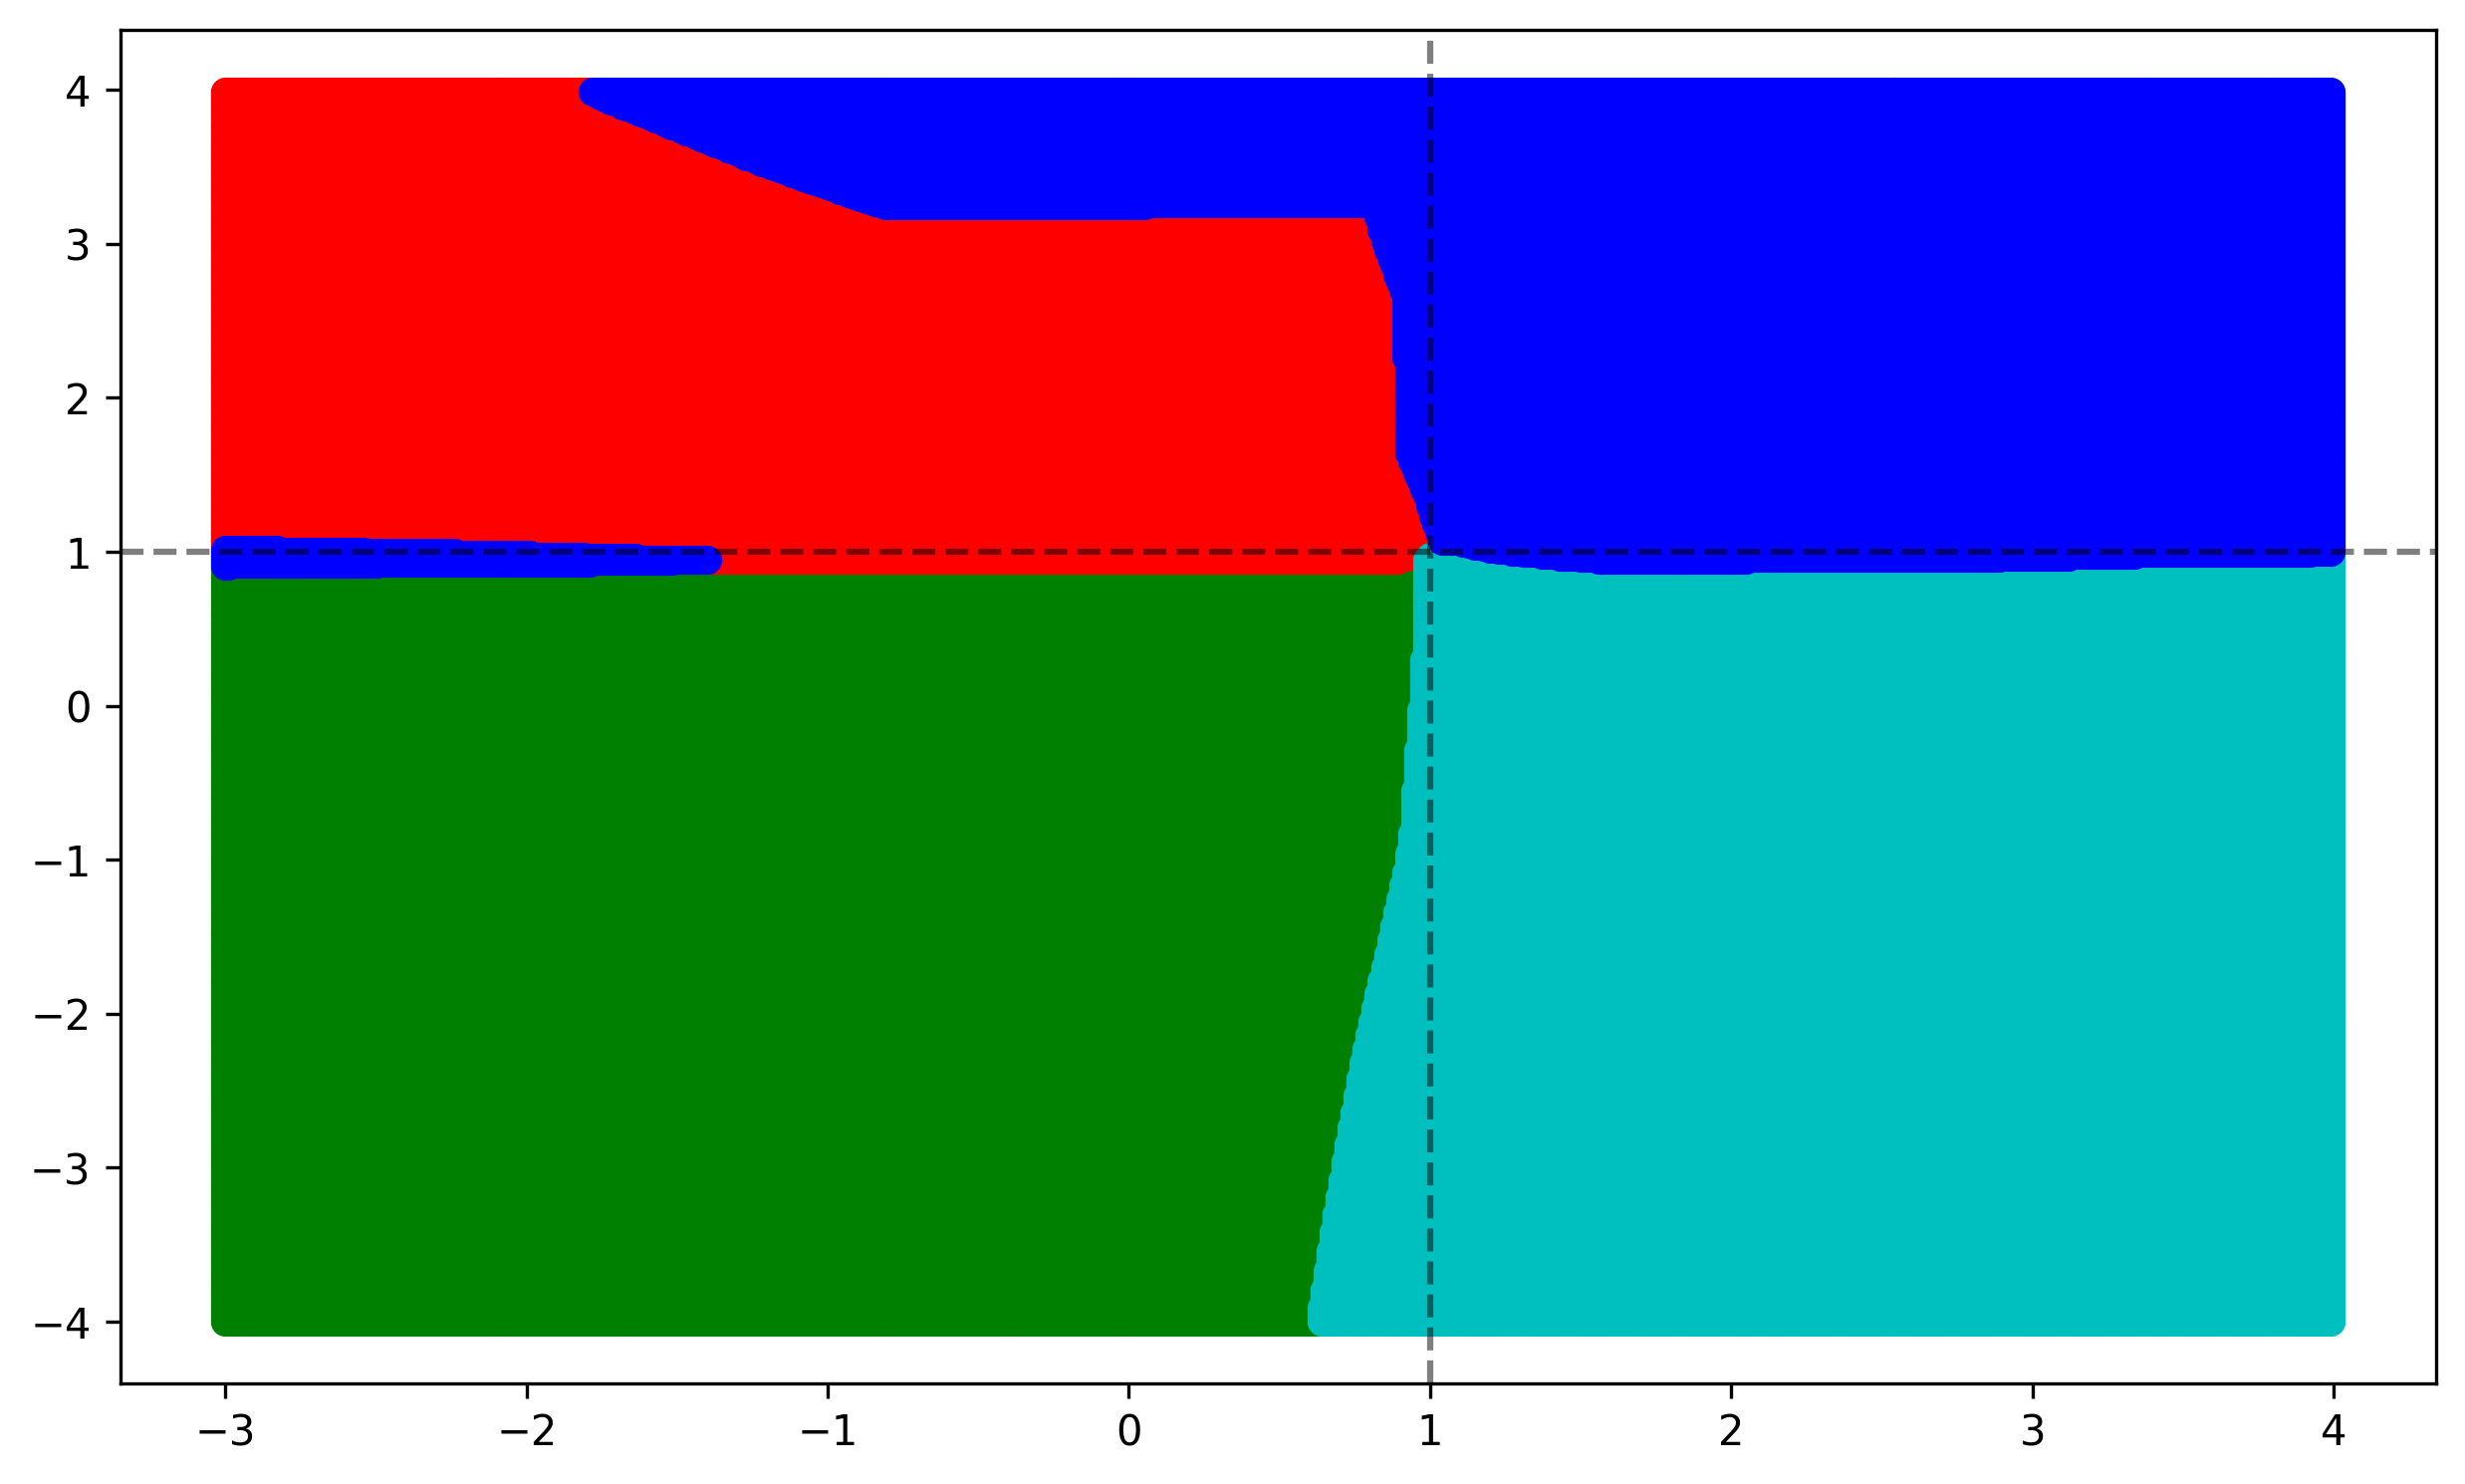

In [59]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)


colors = ['g', 'r', 'c', 'b', 'm', 'y', 'k']
# Plot each data point with its corresponding cluster color
for i, label in enumerate(unique_labels):
    cluster_data = mesh[predicted_clusters == label]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[i], label=f'Cluster {label}')

plt.show()


## Predict new concepts for trajectories in our existing datasets using K-Means model

In [127]:
#Long running code
all_states = np.concatenate(trajectories)
state_wind = wind_predictor.predict(all_states)
state_wind = MinMaxScaler().fit_transform(state_wind) #should only fit this transform once all values have been predicted
state_value = v.predict(all_states)
state_value = MinMaxScaler().fit_transform(state_value)

In [128]:
kmeans_predicted_concepts = []
feature_vectors = []

index = 0
for i,traj in enumerate(trajectories):
    w_s, v_s  = state_wind[index:index+len(traj)], state_value[index:index+len(traj)] 
    index += len(traj)
    trajectory_action_distributions = pi_b.predict(traj)
    feature_vector = np.concatenate([trajectory_action_distributions, w_s, v_s], axis=1)
    feature_vectors.append(feature_vector)
    
feature_vectors_scaled = MinMaxScaler().fit_transform(np.concatenate(feature_vectors)) #must be done after all trajectories have been processed

In [129]:
index = 0
kmeans_predicted_concepts = []
for i,traj in enumerate(trajectories):
    predicted_concepts = kmeans.predict(feature_vectors_scaled[index:index+len(traj)])
    index+=len(traj)
    kmeans_predicted_concepts.append(predicted_concepts)

In [130]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

num_concepts = 4

def actions_to_action_indexes(actions):
    up = [0, 1]
    down = [0, -1]
    right = [1, 0]
    left = [-1, 0]

    # action space
    A = np.array([up, down, right, left])

    '''Returns the index of the action in the state space, e.g. 0 for up, 1 for right etc'''
    indicies = [np.where(np.all((A == a), axis=1))[0][0] for a in actions]
    return np.array(indicies)

def generate_default_concepts_dataset(window_size, concepts=concepts, trajectories=trajectories):
    Y = concepts
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, y_train, y_test

def generate_default_dataset(window_size, concepts=concepts):
    Y = np.concatenate(concepts)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, num_concepts), to_categorical(y_test, num_concepts)

def generate_default_dataset_actions(window_size, actions=actions, trajectories=trajectories):
    actions_indexed = actions_to_action_indexes(np.concatenate(actions))
    Y = actions_indexed.reshape(len(actions_indexed), 1)
    # Y = np.concatenate(actions)
    X = np.concatenate(window_states(trajectories, W_s=window_size))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    return X_train, X_test, to_categorical(y_train, 4), to_categorical(y_test, 4)

def window_states(trajectories, W_s=5):
    '''Replaces each state with the average value of previous W_s states including the current state, smoothing the trajectories.'''
    windowed_trajectories = []
    for traj in trajectories:
        windowed_traj = np.zeros((len(traj), 2))
        for i in range(1, len(traj)+1):
            window = traj[i - min(W_s, i):i]
            windowed_traj[i-1] = np.sum(window, axis=0)/len(window)
        windowed_trajectories.append(windowed_traj)
    return np.array(windowed_trajectories, dtype='object')


In [131]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
from models.concept import ConceptModel

X_train, X_test, y_train, y_test = generate_default_dataset(window_size=5, concepts=kmeans_predicted_concepts)
print(X_train.shape)
print(y_train.shape)
concept_model_kmeans = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
history1 = concept_model_kmeans.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
concept_model_kmeans.save("saved_models/c_4_kmeans|s")
# concept_model_kmeans = keras.models.load_model("saved_models/c_4_kmeans|s") 


(2067930, 2)
(2067930, 4)
Epoch 1/5
51699/51699 [==============================] - 77s 1ms/step - loss: 0.0678 - categorical_accuracy: 0.9713 - val_loss: 0.0645 - val_categorical_accuracy: 0.9721
Epoch 2/5
51699/51699 [==============================] - 62s 1ms/step - loss: 0.0639 - categorical_accuracy: 0.9724 - val_loss: 0.0652 - val_categorical_accuracy: 0.9716
Epoch 3/5
51699/51699 [==============================] - 59s 1ms/step - loss: 0.0634 - categorical_accuracy: 0.9726 - val_loss: 0.0626 - val_categorical_accuracy: 0.9730
Epoch 4/5
51699/51699 [==============================] - 62s 1ms/step - loss: 0.0630 - categorical_accuracy: 0.9728 - val_loss: 0.0625 - val_categorical_accuracy: 0.9726
Epoch 5/5
51699/51699 [==============================] - 67s 1ms/step - loss: 0.0628 - categorical_accuracy: 0.9728 - val_loss: 0.0643 - val_categorical_accuracy: 0.9720
Cause: Unable to locate the source code of <function trace_model_call.<locals>._wrapped_model at 0x7fcf1d867820>. Note that 

In [23]:
# index = 0
# kmeans_predicted_concepts = []
# for i,traj in enumerate(trajectories):
#     predicted_concepts = np.argmax(concept_model_kmeans.predict(traj), axis=1)
#     kmeans_predicted_concepts.append(predicted_concepts)

In [98]:
def plot_concept_decision_boundary(c_model):
    h = .02  # step size in the mesh
    x_min, x_max = -4, 5
    y_min, y_max = -4.5,5.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = np.argmax(c_model.predict(np.c_[xx.ravel(), yy.ravel()]), axis=1)
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    rect = patches.Rectangle([3, 3], 1, 1, fill=True, color="grey", alpha=0.5)
    ax.add_patch(rect)
    plt.axhline(y=1, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=1, color='black', linestyle='--', alpha=0.5)
    colors = ("blue","orange","green","red","red","green")
    ax.contourf(xx, yy, Z, alpha=0.3, zorder=-1)
    # plt.legend()
    plt.show()

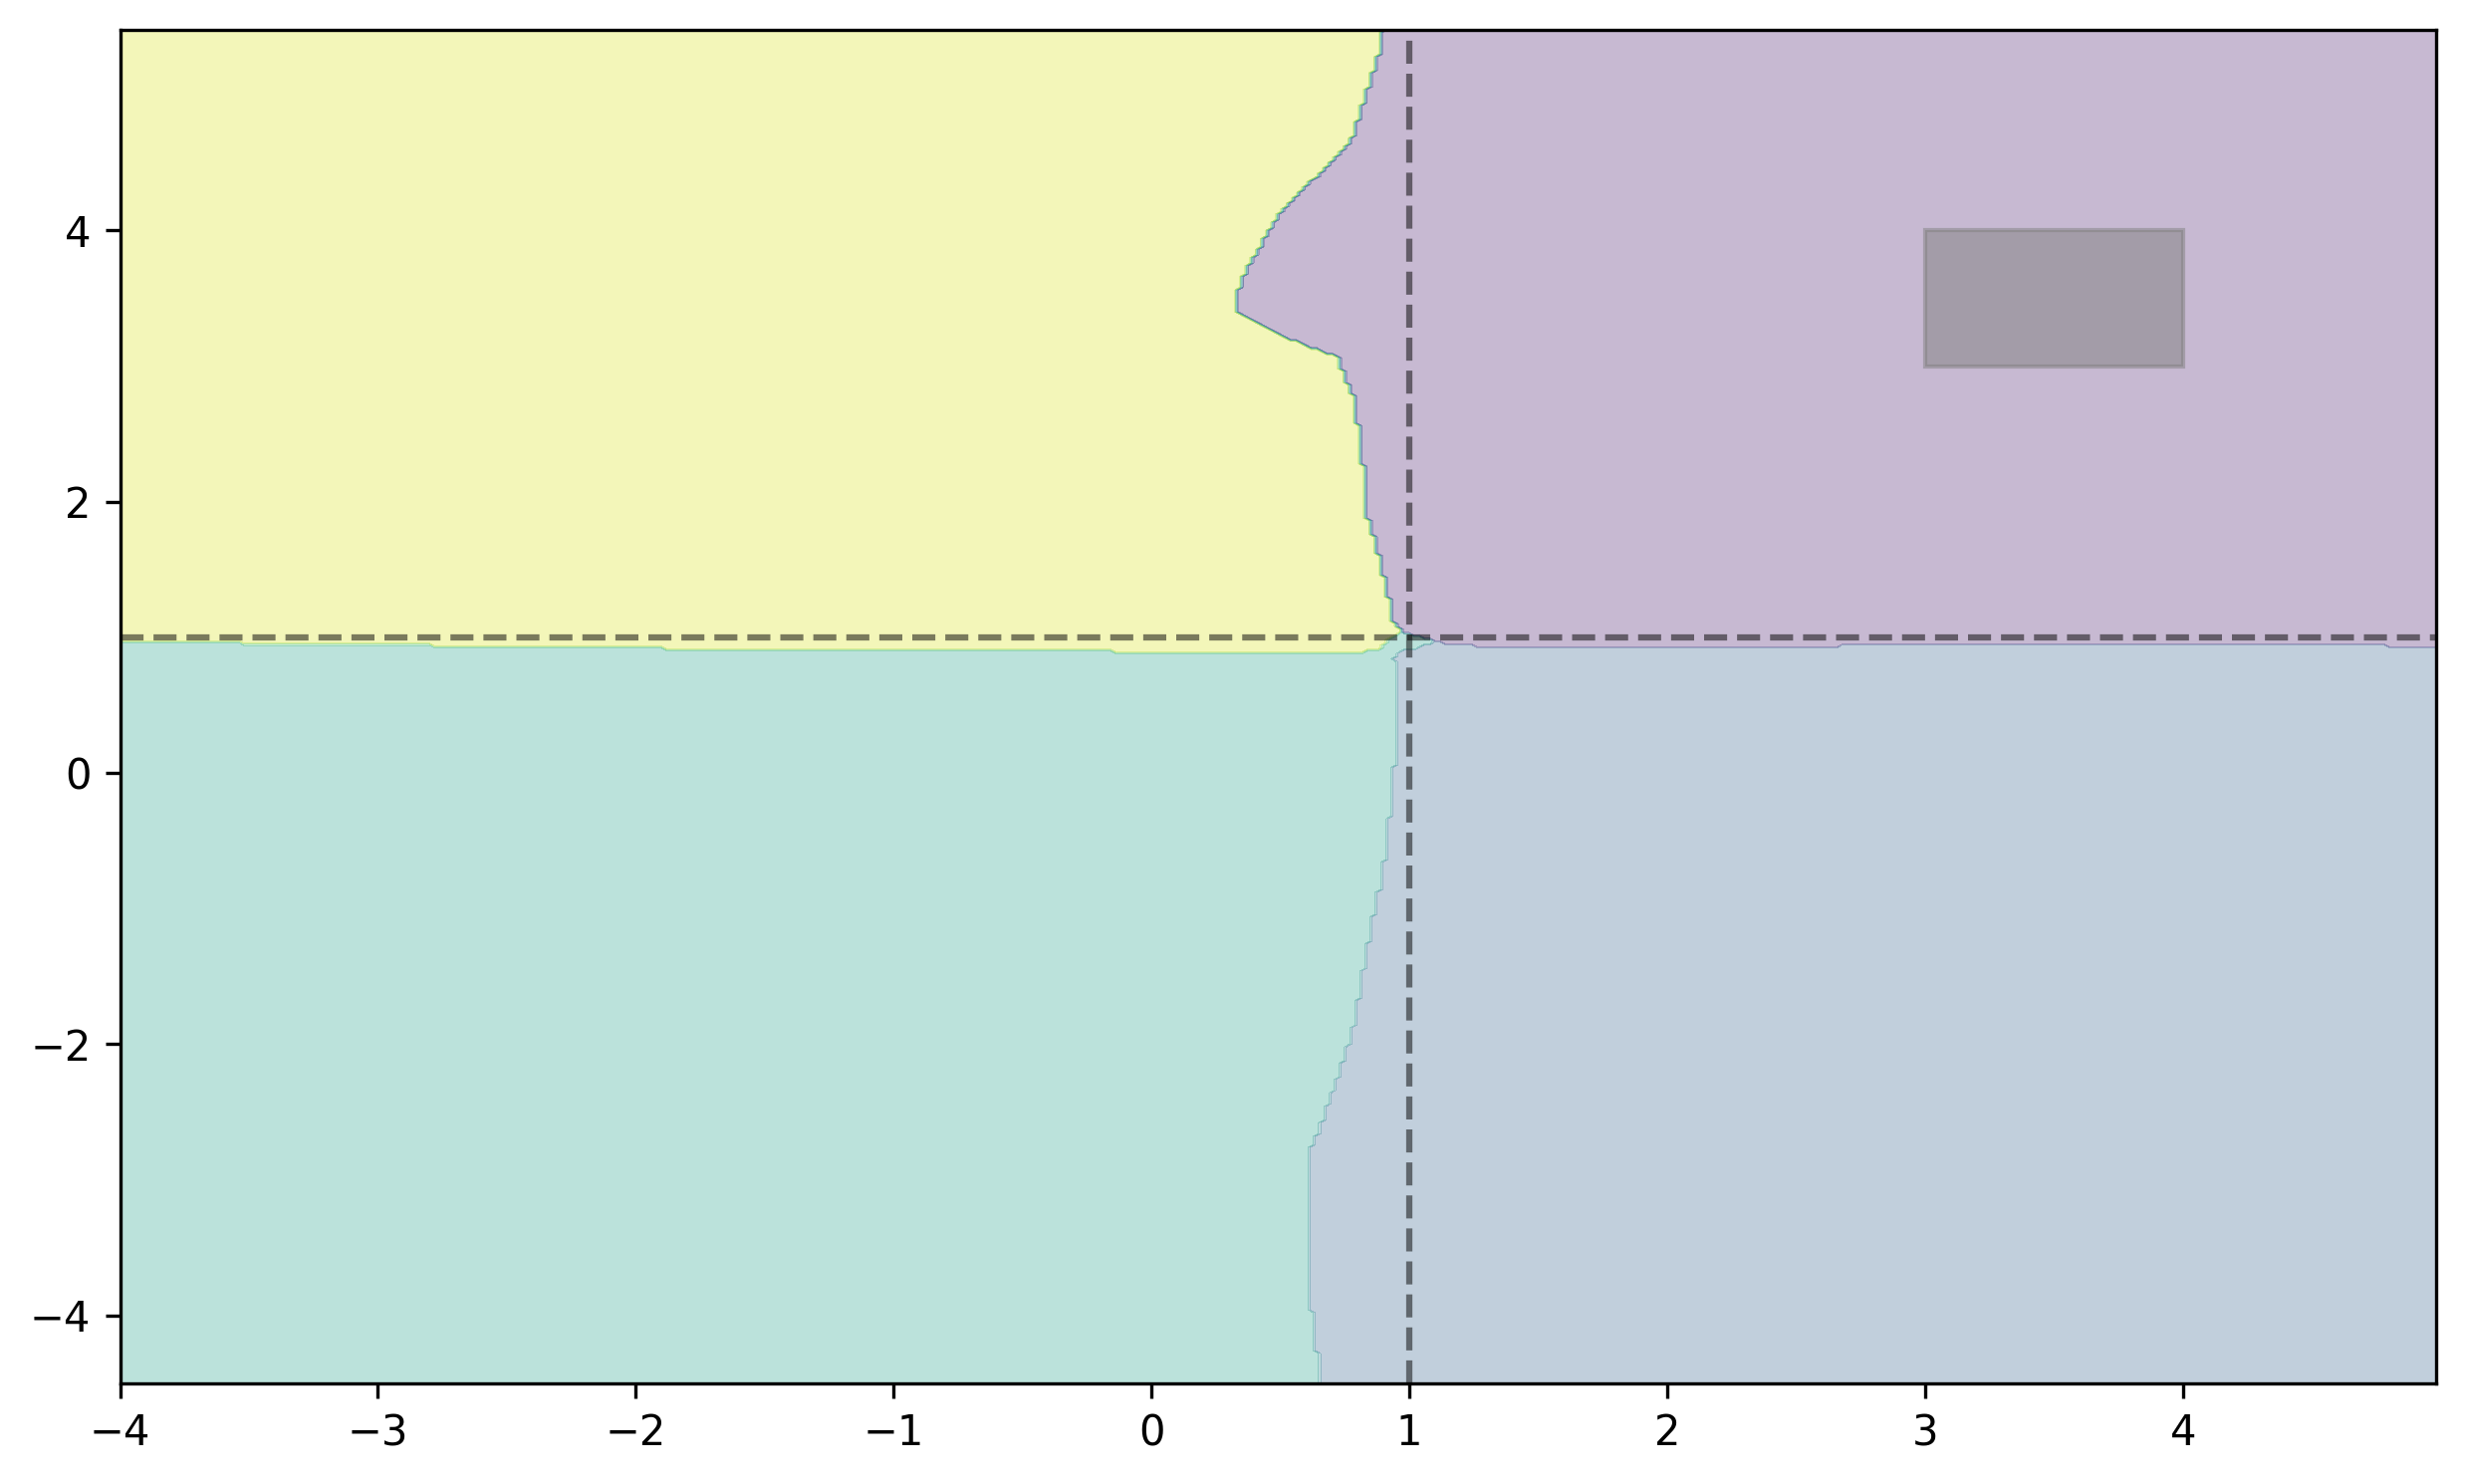

In [133]:
# load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
concept_model_kmeans = keras.models.load_model("saved_models/c_4_kmeans|s") 
plot_concept_decision_boundary(concept_model_kmeans)

In [56]:
# from models.policy import PolicyModel
# X_train, X_test, y_train, y_test = generate_default_dataset_actions(window_size=5)
# #conver to concepts here
# concept_model_kmeans = keras.models.load_model("saved_models/c_4_kmeans|s")
# Xc_train = concept_model_kmeans.predict(X_train)
# Xc_test = concept_model_kmeans.predict(X_test)
# pi_b_c_kmeans = PolicyModel(input_size=Xc_train[0].shape, num_actions=4, loss="mse").build()
# history = pi_b_c_kmeans.fit(Xc_train, y_train, epochs=2, batch_size=32, validation_split=0.2, verbose = 1)
# pi_b_c_kmeans.save("saved_models/pi_b_c_4_kmeans_reg")
pi_b_c_kmeans = keras.models.load_model("saved_models/pi_b_c_4_kmeans_reg")

In [62]:

pi_b_c_opt = keras.models.load_model('saved_models/pi_b_c_optimised')


print(pi_b_c_kmeans.predict(np.array([[1,0,0,0]])))
print(pi_b_c_opt.predict(np.array([[1,0,0,0]])))

[[0.43101096 0.0779039  0.42210197 0.07453368]]
[[0.42564017 0.07413127 0.43005234 0.07017615]]


$$
\hat{V}_{IS}^{\pi_e}(\mathcal{D}) = \frac{1}{|\mathcal{D}|}\sum_{\tau \in \mathcal{D}} g(\tau)\rho(\tau)
$$
where
$$
\rho(\tau) = \prod_{t=1}^{T}\frac{\pi_e(a_t|c_t)}{\pi_b(a_t|c_t)}
$$
and
$$
g(\tau) = \sum_{t=1}^{T} \gamma^{t-1}r_t.
$$

Here $\gamma$ is the discount factor and $\tau \sim \pi_b$

## Optimizing concepts

- we need to minimize the MSE of our estimator w.r.t to the concepts
- decision variable: concept of every state in the above mesh? (this is huge). Or do we optimize the parameters of the kMeans?
- $MSE = Var[\hat{V}_{\pi_e}^c] + bias[\hat{V}_{\pi_e}^c]^2$
- $bias = \hat{V}_{\pi_e}^c - V_{on\ policy}$

In [49]:
D=900
indicies = np.random.choice(len(trajectories), D, replace=False)
sampled_trajectories = trajectories[indicies]
sampled_actions = actions[indicies]
sampled_concepts = np.array(kmeans_predicted_concepts, dtype="object")[indicies]
print(np.concatenate(sampled_trajectories).shape) # number of decision variables

(429246, 2)


In [17]:
print(pi_b_c_kmeans.predict(np.array([[-6.20042009e-23,  2.10461326e-22,  1.00000000e+00 , 1.43666611e-21]])))

[[0.23791933 0.20433328 0.49158671 0.07186375]]


In [51]:
from autograd import grad, elementwise_grad
import copy
import autograd.numpy as np
from autograd.misc.optimizers import adam, sgd


def one_hot_decision_vector(predicted_concepts, num_concepts):
    predicted_concept_per_state = np.concatenate(predicted_concepts)
    v = np.zeros((len(predicted_concept_per_state), num_concepts))
    for i in range(len(v)):
        v[i][predicted_concept_per_state[i]] = 1.0
    return v


def eval_policy_by_concept(c):
    if c == 0:
        return np.array([0.48, 0.02, 0.48, 0.02])
    elif c == 1:
        return np.array([0.53, 0.02, 0.35, 0.1])
    elif c == 2:
        return np.array([0.2, 0.2, 0.58, 0.02])
    else:
        return np.array([0.68, 0.02, 0.28, 0.02])
    

def relu(x):
    return np.maximum(0.01, x)


def softmax(x):
    """applies softmax to an input x"""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtracting max along each row
    return e_x / e_x.sum(axis=1, keepdims=True)


pi_b_c_params = []
for i in range(len(pi_b_c_kmeans.layers)):
    layer_weights = pi_b_c_kmeans.layers[i].get_weights()
    pi_b_c_params.append(
        (layer_weights[0], layer_weights[1])
    )  # (Weights, bias) tuple for each layer


def predict_actions_from_concepts(params, input):
    for W, b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return output


v_on_policy = -477


c = one_hot_decision_vector(sampled_concepts, num_concepts=4)
trajectory_lengths = np.array([len(traj) for traj in sampled_trajectories], dtype="object")
actions_indicies_taken = np.array([actions_to_action_indexes(actions) for actions in sampled_actions], dtype="object")

# behaviour_distrtibution_lookup = np.array([pi_b_c_kmeans.predict(np.array([concept_one_hot]))[0] for concept_one_hot in [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]])


def mse_loss(c, iter):
    """
    Input: decision_variables: a vector of one_hot encodings of the concept at every state in the dataset. Shape: (sum(len(traj) in D) x num_concepts)

    Other required paramaters (which can't be passed in as arguments due to Autograd's workings)
    - trajectory_lengths: a list of the lengths of each trajectory in the dataset
    - actions_taken: a list of the actions taken at each state in the dataset (index of action in the action space)
    - v_on_policy
    - pi_b_c: the behaviour policy model over concepts: concept one_hot -> action distribution
    - eval_policy: possibly a function to introduce eval_policy randomly
    """
    index = 0
    squared_errors = []
    for i, _ in enumerate(sampled_trajectories):
        """
        Compute squared error for each trajectory before taking mean
        """
        T = trajectory_lengths[i]
        decision_variables_for_trajectory = c[index : index + T]
        index += T

        denominator = predict_actions_from_concepts(pi_b_c_params, decision_variables_for_trajectory)
        r, _ = denominator.shape
        denominator_probabilities = denominator[np.arange(r), actions_indicies_taken[i]]
        concepts_for_trajectory = np.argmax(decision_variables_for_trajectory, axis=1)
        numerator = np.array([eval_policy_by_concept(c) for c in concepts_for_trajectory])
        r, _ = numerator.shape
        numerator_probabilities = numerator[np.arange(r), actions_indicies_taken[i]]
     
        trajectory_ratios = (numerator_probabilities / denominator_probabilities)  # importance sampling ratios
        importance_weight = np.prod(trajectory_ratios) * 100000 # is this allowed?
        V = importance_weight * T * -1  # per trajectory estimate (i.e. D=1)
        
        squared_errors.append((V - v_on_policy) ** 2)

    return np.mean(np.array(squared_errors))



loss_gradient = grad(mse_loss)

print("     Epoch     |    MSE")
def print_perf(params, iter, gradient):
    mse = mse_loss(params, iter)
    print("{:15}|{:20}".format(iter, mse))

objective_grad = grad(mse_loss)
optimized_params = adam(objective_grad, c, step_size=0.003, num_iters=100, callback=print_perf)

     Epoch     |    MSE
              0|  227528.99447093657
              1|   227528.9894513001
              2|  227528.98016400007
              3|  227528.95815117826
              4|  227528.91397059878
              5|   227528.8210327739
              6|   227528.6297858536
              7|  227528.23933483133
              8|  227527.45720504972
              9|  227525.86229800477
             10|  227522.51809695378
             11|  227515.64212011226
             12|   227501.7068224171
             13|  227476.62424516285
             14|  227429.69949847565
             15|  227335.15120968435
             16|   227143.1527242497
             17|  227518.72070484576
             18|   227103.0953332868
             19|   226756.6548793725
             20|  226648.85639732398
             21|  227469.51417236924
             22|   226735.3527704571
             23|   226686.2688787526
             24|  226561.45855626397
             25|  227152.73373511047
             2

#### Now retrain a concept model with new optimised concepts at each state
- necesarry since we will need the pi_b_c_optimised predictor for running OPE

In [43]:
class ConceptModel():
    model = None

    def __init__(self, input_size, num_concepts) -> None:
        self.input_size = input_size
        self.output_size = num_concepts
    
    def build(self):
        model = Sequential()
        model.add(Dense(64, activation="relu", input_shape=self.input_size))
        model.add(Dense(128, activation="relu"))
        model.add(Dense(self.output_size, activation="linear"))

        model.compile(optimizer='adam',loss='mse', metrics=['mse'])
        self.model = model
        return model

In [101]:
# from models.concept import ConceptModel
# X_train, X_test, y_train, y_test = generate_default_concepts_dataset(window_size=5, concepts=optimized_params, trajectories=sampled_trajectories)
# print(X_train.shape)
# print(y_train.shape)
# concept_model_optimised = ConceptModel(input_size=X_train[0].shape, num_concepts=num_concepts).build()
# history1 = concept_model_optimised.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose = 1)
# concept_model_kmeans.save("saved_models/c_4_optimised_d200|s")
concept_model_optimised = keras.models.load_model("saved_models/c_4_optimised|s")

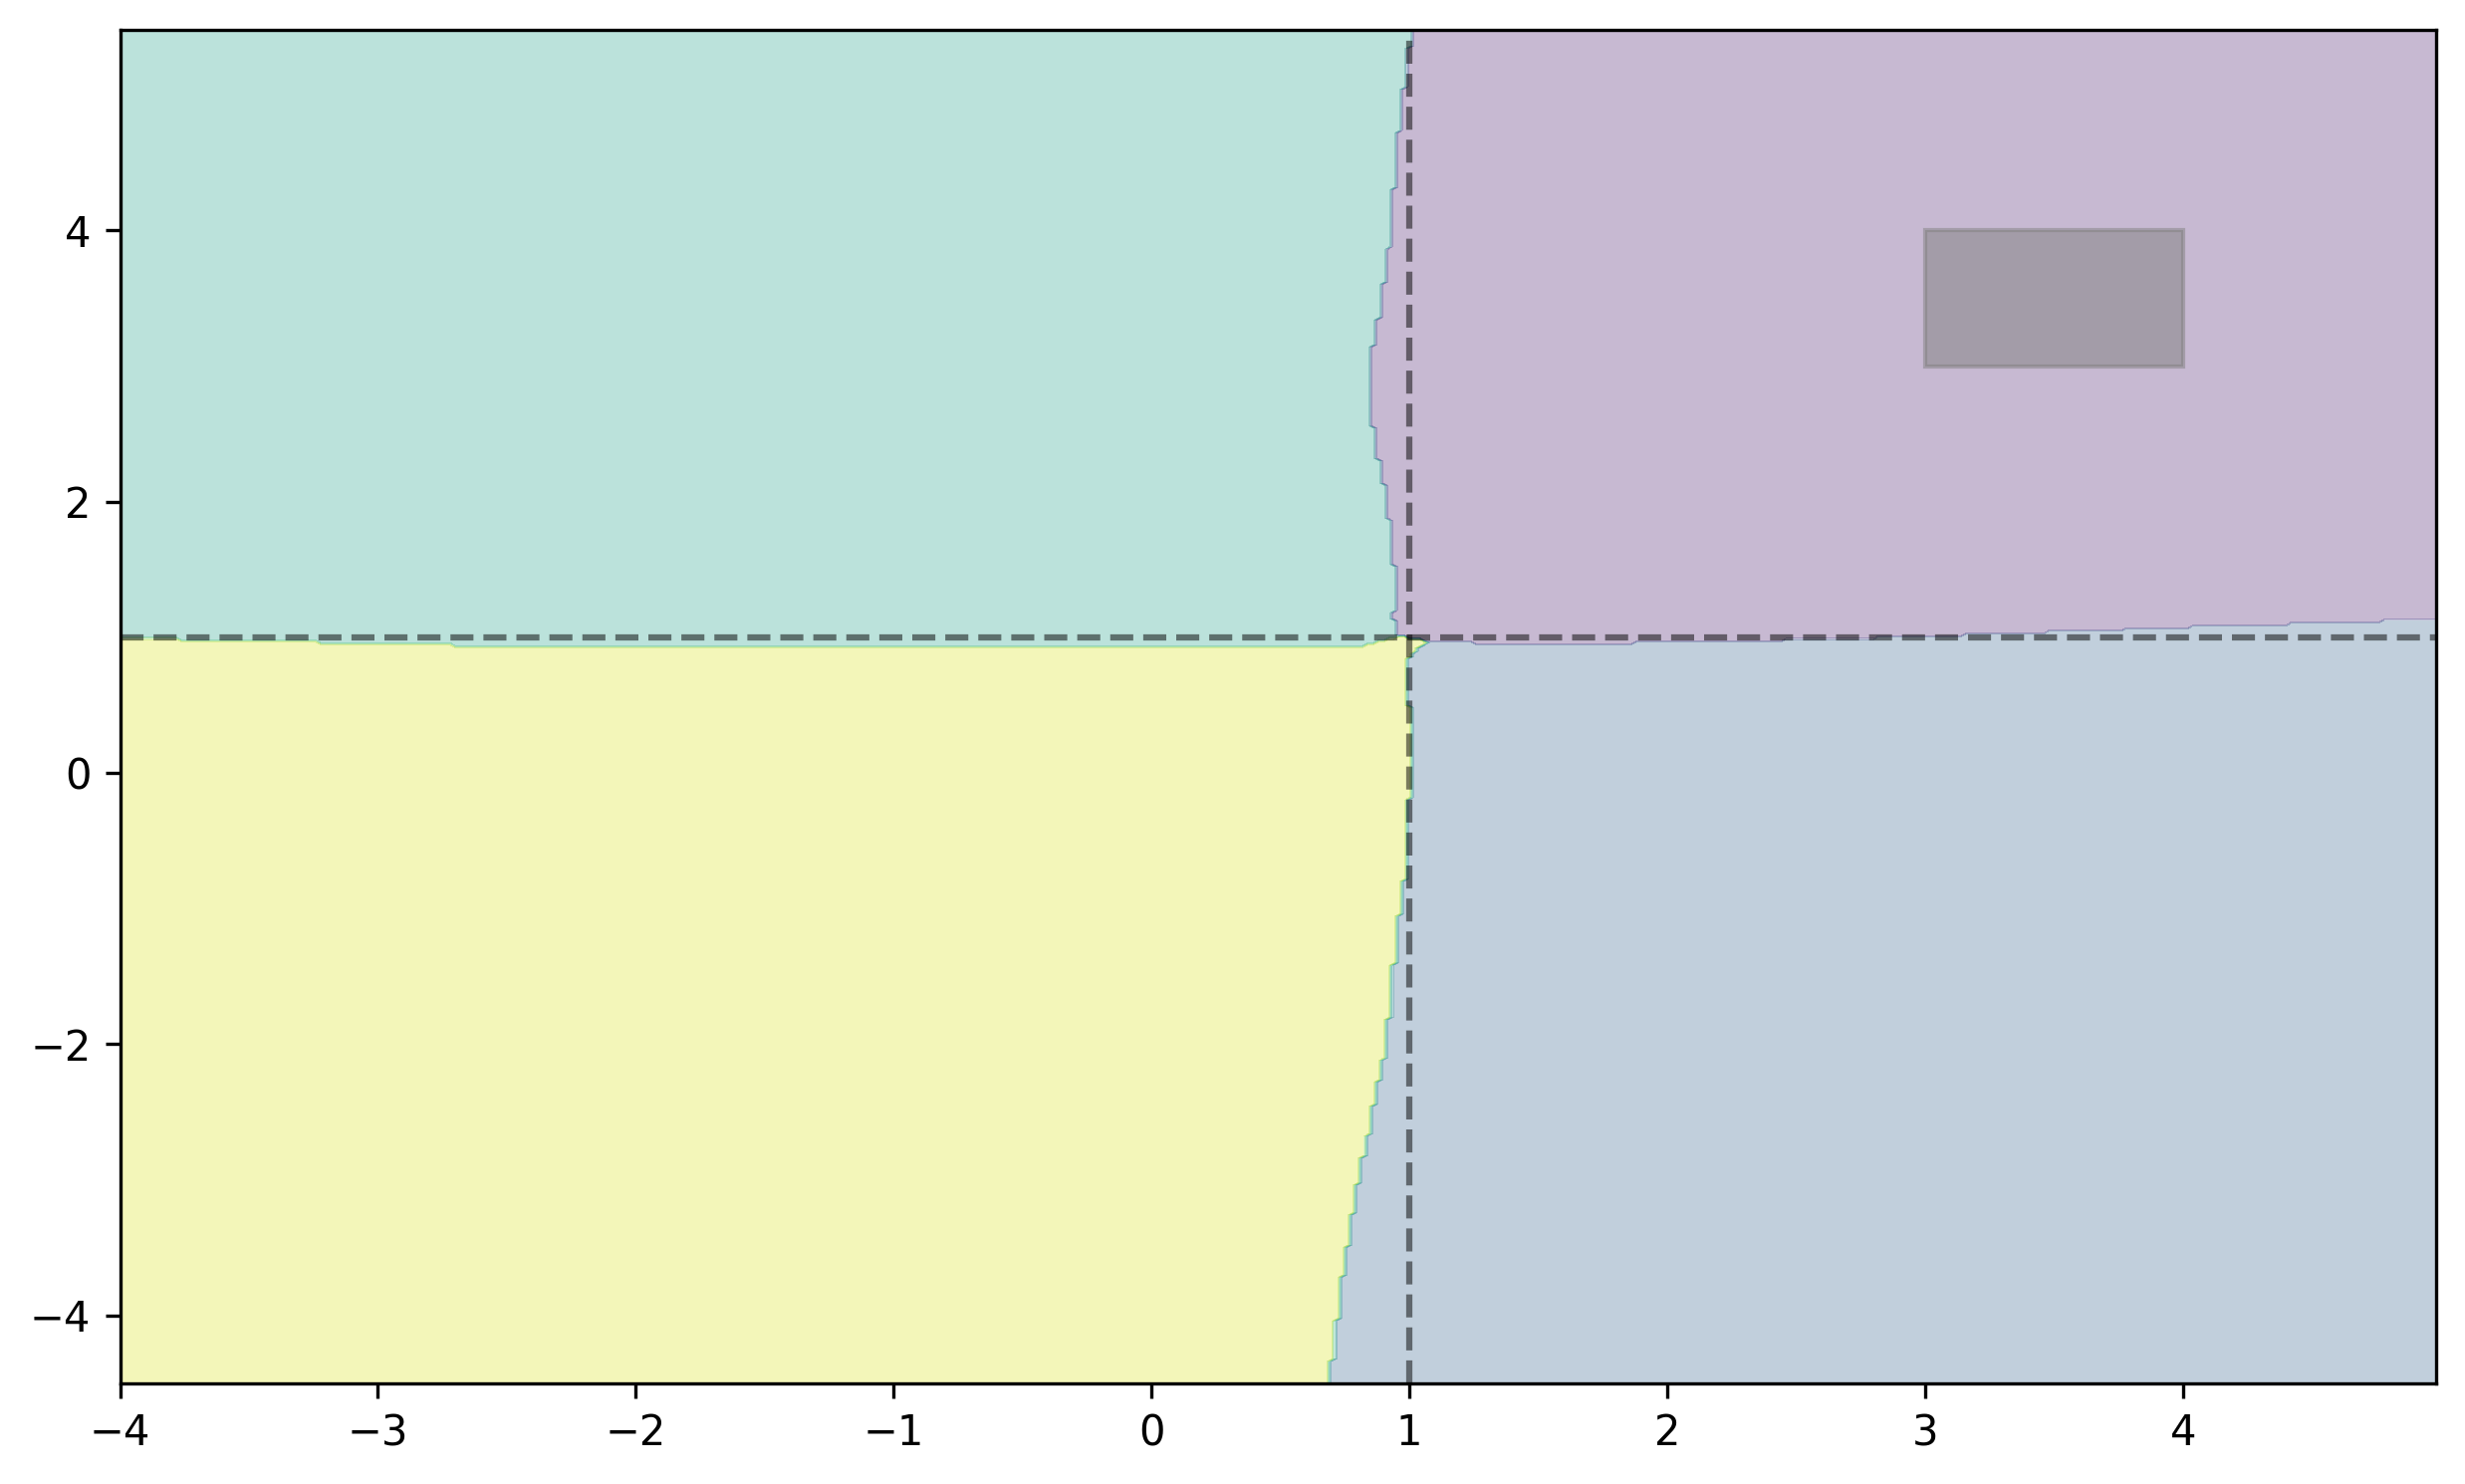

In [103]:
concept_model_optimised = keras.models.load_model("saved_models/c_4_optimised|s")
plot_concept_decision_boundary(concept_model_optimised)

In [82]:
from models.policy import PolicyModel
X_train, X_test, y_train, y_test = generate_default_dataset_actions(window_size=5, actions=sampled_actions, trajectories=sampled_trajectories)
#conver to concepts here
concept_model_optimised = keras.models.load_model("saved_models/c_4_optimised|s")
Xc_train = concept_model_optimised.predict(X_train)
Xc_test = concept_model_optimised.predict(X_test)
pi_b_c_optimised = PolicyModel(input_size=Xc_train[0].shape, num_actions=4, loss="categorical_crossentropy").build()
history = pi_b_c_optimised.fit(Xc_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose = 1)
pi_b_c_optimised.save("saved_models/pi_b_c_optimised")

Epoch 1/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1399 - categorical_accuracy: 0.4613 - val_loss: 1.1403 - val_categorical_accuracy: 0.4600
Epoch 2/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1388 - categorical_accuracy: 0.4607 - val_loss: 1.1387 - val_categorical_accuracy: 0.4622
Epoch 3/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1386 - categorical_accuracy: 0.4606 - val_loss: 1.1384 - val_categorical_accuracy: 0.4601
Epoch 4/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1384 - categorical_accuracy: 0.4604 - val_loss: 1.1403 - val_categorical_accuracy: 0.4622
Epoch 5/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1383 - categorical_accuracy: 0.4607 - val_loss: 1.1387 - val_categorical_accuracy: 0.4599
Epoch 6/10
19075/19075 [==============================] - 22s 1ms/step - loss: 1.1382 - categorical_accuracy: 0.4608 - val_loss: 1.1385 - val_cat

In [83]:
pi_b_c_optimised.predict(np.array([[1,0,0,0]]))

array([[0.42564017, 0.07413127, 0.43005234, 0.07017615]], dtype=float32)

## Try optimize weights of states -> concept predictor instead

In [134]:
from autograd import grad, elementwise_grad
import copy
from autograd.misc.optimizers import adam
import autograd.numpy as np #important


def eval_policy_by_concept(c):
    if c == 0:
        return np.array([0.48, 0.02, 0.48, 0.02])
    elif c == 1:
        return np.array([0.53, 0.02, 0.35, 0.1])
    elif c == 2:
        return np.array([0.2, 0.2, 0.58, 0.02])
    else:
        return np.array([0.68, 0.02, 0.28, 0.02])


def relu(x):
    return np.maximum(0, x)

def softmax(x):
    """ applies softmax to an input x"""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtracting max along each row
    return e_x / e_x.sum(axis=1, keepdims=True)

pi_b_c_params = []
for i in range(len(pi_b_c_kmeans.layers)):
    layer_weights = pi_b_c_kmeans.layers[i].get_weights()
    pi_b_c_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer


concept_model_params = []
for i in range(len(concept_model_kmeans.layers)):
    layer_weights = concept_model_kmeans.layers[i].get_weights()
    concept_model_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer

def predict_concept_from_states(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return softmax(output)

def predict_actions_from_concepts(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return output

    
v_on_policy = -477
    
trajectory_lengths = np.array([len(traj) for traj in sampled_trajectories], dtype='object')
actions_indicies_taken = np.array([actions_to_action_indexes(actions) for actions in sampled_actions], dtype='object')

def mse_loss(concept_model_params, iter):
    '''
    Input: decision_variables: a vector of one_hot encodings of the concept at every state in the dataset. Shape: (sum(len(traj) in D) x num_concepts)

    Other required paramaters (which can't be passed in as arguments due to Autograd's workings)
    - trajectory_lengths: a list of the lengths of each trajectory in the dataset
    - actions_taken: a list of the actions taken at each state in the dataset (index of action in the action space)
    - v_on_policy
    - pi_b_c: the behaviour policy model over concepts: concept one_hot -> action distribution
    - eval_policy: possibly a function to introduce eval_policy randomly
    '''
    epsilon = 0.2
    index = 0
    squared_errors = []
    for i, traj in enumerate(sampled_trajectories):
        '''
        Compute squared error for each trajectory before taking mean
        '''
        T = len(traj)
        # decision_variables_for_trajectory = c[index:index+T]
        index += T
        
        trajectory_concepts = predict_concept_from_states(concept_model_params, traj)
        trajectory_action_distributions = predict_actions_from_concepts(pi_b_c_params, trajectory_concepts) #behaviour distributions

        r,_ = trajectory_action_distributions.shape
        denominator_probabilities = trajectory_action_distributions[np.arange(r), actions_indicies_taken[i]] #pi_b
        numerator = np.array([eval_policy_by_concept(c) for c in np.argmax(trajectory_concepts, axis=1)])

        r,_ = numerator.shape
        numerator_probabilities = numerator[np.arange(r), actions_indicies_taken[i]] #pi_e

        
        trajectory_ratios = numerator_probabilities/denominator_probabilities #importance sampling ratios

        importance_weight = np.prod(trajectory_ratios)
        V = importance_weight * T * -1  # per trajectory estimate (i.e. D=1)
        squared_errors.append((V - v_on_policy) ** 2)
       
    
    return np.mean(np.array(squared_errors))



print("     Epoch     |    MSE")
def print_perf(params, iter, gradient):
    mse = mse_loss(params,0)
    print("{:15}|{:20}".format(iter, mse))

objective_grad = grad(mse_loss)
optimized_params = adam(objective_grad, concept_model_params, step_size=0.1, num_iters=10, callback=print_perf)
  

     Epoch     |    MSE
              0|   227528.9940254136
              1|   227528.9998807109
              2|  227528.99999983032
              3|   227528.9999999521


In [28]:
pi_b_c_params = []
for i in range(len(pi_b_c_kmeans.layers)):
    layer_weights = pi_b_c_kmeans.layers[i].get_weights()
    pi_b_c_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer


concept_model_params = []
for i in range(len(concept_model_kmeans.layers)):
    layer_weights = concept_model_kmeans.layers[i].get_weights()
    concept_model_params.append((layer_weights[0], layer_weights[1])) #(Weights, bias) tuple for each layer

def predict_concept_from_states(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return softmax(output)

def predict_actions_from_concepts(params, input):
    for W,b in params:
        output = np.dot(input, W) + b
        input = relu(output)
    return output

input = np.array([[0,0,0,1], [1,0,0,0]])
print(pi_b_c_kmeans.predict(input))
print(predict_actions_from_concepts(pi_b_c_params, input))

input = np.array([[-3,-3], [2,2]])
print(concept_model_kmeans.predict(input))
print(predict_concept_from_states(concept_model_params, input))

[[0.56807864 0.08468597 0.27834916 0.08192624]
 [0.43101096 0.0779039  0.42210197 0.07453368]]
[[0.56807866 0.08468597 0.27834917 0.08192624]
 [0.43101095 0.0779039  0.42210196 0.07453368]]
[[0.0000000e+00 8.7615320e-25 0.0000000e+00 1.0000000e+00]
 [1.0000000e+00 4.6998561e-21 4.1863248e-16 7.5148195e-21]]
[[4.22692941e-83 8.76151006e-25 1.14848219e-54 1.00000000e+00]
 [1.00000000e+00 4.69985902e-21 4.18631818e-16 7.51481789e-21]]
